In [37]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
accident = pd.read_csv('https://raw.githubusercontent.com/Uthmanic/07-road-safety/master/data/dftRoadSafety_Accidents_2016.csv')
accident_data = accident.copy()

vehicle = pd.read_csv('https://raw.githubusercontent.com/Uthmanic/07-road-safety/master/data/Veh.csv')
vehicle_data = vehicle.copy()

#casualty = pd.read_csv('https://raw.githubusercontent.com/Uthmanic/07-road-safety/master/data/Cas.csv')
#casualty_data = casualty.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
accident_data.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,3,02:30,28,E09000005,3,4006,6,30.0,0,-1,-1,0,0,0,5,1,1,0,0,1,1,E01000543
1,2016010000006,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,3,00:37,18,E09000004,3,207,6,30.0,9,4,6,0,0,0,4,1,1,0,0,1,1,E01000375
2,2016010000008,505930.0,183850.0,-0.473837,51.543563,1,3,1,1,01/11/2016,3,01:25,26,E09000017,3,4020,1,30.0,1,4,3,4020,0,0,4,1,1,0,0,1,1,E01033725
3,2016010000016,527770.0,168930.0,-0.164442,51.404958,1,3,1,1,01/11/2016,3,09:15,22,E09000024,3,217,6,30.0,3,2,3,217,0,0,1,1,1,0,0,1,1,E01003379
4,2016010000018,510740.0,177230.0,-0.406580,51.483139,1,3,2,1,01/11/2016,3,07:53,25,E09000018,3,312,3,40.0,0,-1,-1,0,0,0,1,1,1,0,0,1,1,E01002583


In [4]:
vehicle_data.head()

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile
0,2016010000005,1,8,0,6,0,0,0,0,0,0,3,1,1,1,51,8,-1,-1,-1,3,1,3
1,2016010000005,2,2,0,18,0,0,0,0,0,0,1,1,6,1,23,5,124,1,4,4,1,4
2,2016010000006,1,9,0,18,0,2,2,10,1,0,4,1,6,2,36,7,1461,2,1,10,1,10
3,2016010000008,1,9,0,18,0,4,5,0,0,0,1,1,6,1,24,5,1390,1,5,8,1,8
4,2016010000016,1,11,0,18,0,1,0,0,0,0,0,1,1,1,55,8,6692,2,7,9,1,9


In [24]:
# Merging vehicle and accident data sets for Accident severity prediction
all_data = pd.merge(vehicle_data, accident_data, how = 'inner', on = 'Accident_Index')

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252500 entries, 0 to 252499
Data columns (total 54 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               252500 non-null  object 
 1   Vehicle_Reference                            252500 non-null  int64  
 2   Vehicle_Type                                 252500 non-null  int64  
 3   Towing_and_Articulation                      252500 non-null  int64  
 4   Vehicle_Manoeuvre                            252500 non-null  int64  
 5   Vehicle_Location-Restricted_Lane             252500 non-null  int64  
 6   Junction_Location                            252500 non-null  int64  
 7   Skidding_and_Overturning                     252500 non-null  int64  
 8   Hit_Object_in_Carriageway                    252500 non-null  int64  
 9   Vehicle_Leaving_Carriageway                  252500 non-nul

**Feature Transformation - Extract month and year from timestamp features**

In [7]:
# functions to extract year and month from 'Date' column

from datetime import datetime
# save month to a new column from 'date' column
def month(date):
    fulldate = datetime.strptime(date, '%d/%m/%Y')
    return int(datetime.strftime(fulldate, '%m'))
all_data['Month'] = all_data['Date'].apply(month)

# save year to a new column from 'date' column
def year(date):
    fulldate = datetime.strptime(date, '%d/%m/%Y')
    return int(datetime.strftime(fulldate, '%Y'))
all_data['Year'] = all_data['Date'].apply(year)

In [8]:
# functions to extract hour from 'Time' column
def hour(time):
    try:
        fulltime = datetime.strptime(time, '%H:%M')
        return int(datetime.strftime(fulltime, '%H'))
    except Exception:
        # for missing values 
        return 0

all_data['Hour_of_the_day'] = all_data['Time'].apply(hour)

In [9]:
all_data.head()

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Month,Year,Hour_of_the_day
0,2016010000005,1,8,0,6,0,0,0,0,0,0,3,1,1,1,51,8,-1,-1,-1,3,1,3,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,3,02:30,28,E09000005,3,4006,6,30.0,0,-1,-1,0,0,0,5,1,1,0,0,1,1,E01000543,11,2016,2
1,2016010000005,2,2,0,18,0,0,0,0,0,0,1,1,6,1,23,5,124,1,4,4,1,4,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,3,02:30,28,E09000005,3,4006,6,30.0,0,-1,-1,0,0,0,5,1,1,0,0,1,1,E01000543,11,2016,2
2,2016010000006,1,9,0,18,0,2,2,10,1,0,4,1,6,2,36,7,1461,2,1,10,1,10,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,3,00:37,18,E09000004,3,207,6,30.0,9,4,6,0,0,0,4,1,1,0,0,1,1,E01000375,11,2016,0
3,2016010000008,1,9,0,18,0,4,5,0,0,0,1,1,6,1,24,5,1390,1,5,8,1,8,505930.0,183850.0,-0.473837,51.543563,1,3,1,1,01/11/2016,3,01:25,26,E09000017,3,4020,1,30.0,1,4,3,4020,0,0,4,1,1,0,0,1,1,E01033725,11,2016,1
4,2016010000016,1,11,0,18,0,1,0,0,0,0,0,1,1,1,55,8,6692,2,7,9,1,9,527770.0,168930.0,-0.164442,51.404958,1,3,1,1,01/11/2016,3,09:15,22,E09000024,3,217,6,30.0,3,2,3,217,0,0,1,1,1,0,0,1,1,E01003379,11,2016,9


**Data Cleaning**

In [10]:
# drop un-useful columns for prediction
all_data.drop(['LSOA_of_Accident_Location', 'Local_Authority_(Highway)', 'Time', 'Date'], axis=1, inplace=True)

In [11]:
all_data.isnull().sum()

Accident_Index                                  0
Vehicle_Reference                               0
Vehicle_Type                                    0
Towing_and_Articulation                         0
Vehicle_Manoeuvre                               0
Vehicle_Location-Restricted_Lane                0
Junction_Location                               0
Skidding_and_Overturning                        0
Hit_Object_in_Carriageway                       0
Vehicle_Leaving_Carriageway                     0
Hit_Object_off_Carriageway                      0
1st_Point_of_Impact                             0
Was_Vehicle_Left_Hand_Drive?                    0
Journey_Purpose_of_Driver                       0
Sex_of_Driver                                   0
Age_of_Driver                                   0
Age_Band_of_Driver                              0
Engine_Capacity_(CC)                            0
Propulsion_Code                                 0
Age_of_Vehicle                                  0


In [12]:
all_data.dropna(inplace=True)

In [13]:
all_data.isnull().sum()

Accident_Index                                 0
Vehicle_Reference                              0
Vehicle_Type                                   0
Towing_and_Articulation                        0
Vehicle_Manoeuvre                              0
Vehicle_Location-Restricted_Lane               0
Junction_Location                              0
Skidding_and_Overturning                       0
Hit_Object_in_Carriageway                      0
Vehicle_Leaving_Carriageway                    0
Hit_Object_off_Carriageway                     0
1st_Point_of_Impact                            0
Was_Vehicle_Left_Hand_Drive?                   0
Journey_Purpose_of_Driver                      0
Sex_of_Driver                                  0
Age_of_Driver                                  0
Age_Band_of_Driver                             0
Engine_Capacity_(CC)                           0
Propulsion_Code                                0
Age_of_Vehicle                                 0
Driver_IMD_Decile   

In [14]:
all_data['Accident_Severity'].value_counts()

3    212040
2     37361
1      3022
Name: Accident_Severity, dtype: int64

**Building Predictive Models**

In [16]:
# assign features and the target class
X = all_data.drop(columns=['Accident_Index', 'Accident_Severity'])
y = all_data['Accident_Severity']

In [26]:
#split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [27]:
#importing Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=1)

#fit train set
RFC.fit(x_train, y_train)

# predict test set
RFC_pred = RFC.predict(x_test)

# accuracy of test set
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix
RFC_f1 = f1_score(y_test, RFC_pred,average='micro')
print('RFC f1_score: {}'.format(RFC_f1))

RFC f1_score: 0.8474520316399697


In [28]:
#importing LGBM classifier
from lightgbm import LGBMClassifier
LGBM = LGBMClassifier(random_state=1)

#fit train set
LGBM.fit(x_train, y_train)

# predict test set
LGBM_pred = LGBM.predict(x_test)

# accuracy of test set
LGBM_f1 = f1_score(y_test, LGBM_pred,average='micro')
print('LGBM f1_score: {}'.format(LGBM_f1))

LGBM f1_score: 0.8444412164749693


In [29]:
#importing XGBoost classifier
from xgboost import XGBClassifier
XGB = XGBClassifier(random_state=1)

#fit train set
XGB.fit(x_train, y_train)

# predict test set
XGB_pred = XGB.predict(x_test)

# accuracy of test set
XGB_f1 = f1_score(y_test, XGB_pred, average='micro')
print('XGB f1_score: {}'.format(XGB_f1))

XGB f1_score: 0.8425264436726663


In [30]:
# importing extra tree classifier
from sklearn.ensemble import ExtraTreesClassifier
ETC = ExtraTreesClassifier(random_state=1)

#fit train set
ETC.fit(x_train, y_train)

# predict test set
ETC_pred = ETC.predict(x_test)

# accuracy of test set
ETC_f1 = f1_score(y_test, ETC_pred, average='micro')
print('ETC f1_score: {}'.format(ETC_f1))

ETC f1_score: 0.846738943837733


Of all the models executed, Random Forest Classifier has the best f1_score and will be a perfect choice

In [31]:
feature = X.columns

# features importance
feat_importance = pd.DataFrame(RFC.feature_importances_,index=feature)
feat = feat_importance.sort_values(0)
feat

,0
Year,0.000000
Was_Vehicle_Left_Hand_Drive?,0.000952
Pedestrian_Crossing-Human_Control,0.001283
Towing_and_Articulation,0.002431
Carriageway_Hazards,0.002473
Special_Conditions_at_Site,0.003421
Vehicle_Location-Restricted_Lane,0.003648
Hit_Object_in_Carriageway,0.005083
Hit_Object_off_Carriageway,0.006075
Urban_or_Rural_Area,0.006494


In [35]:
#function for ploting models feature importance bar chart

def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

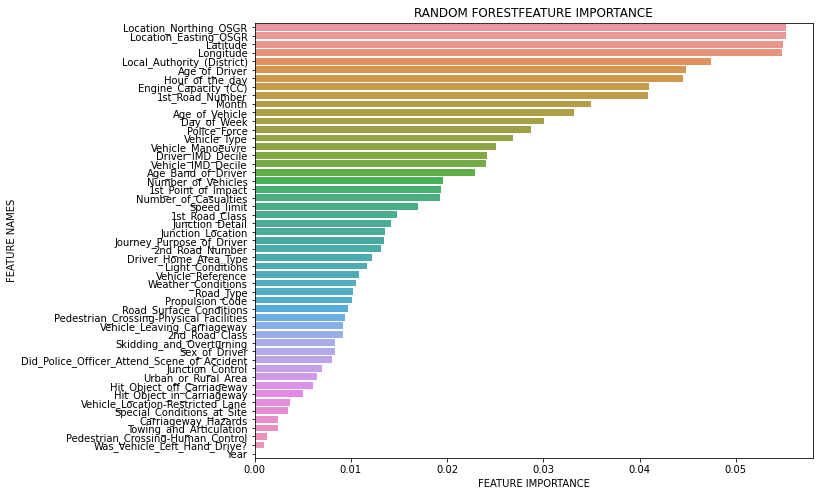

In [38]:
plot_feature_importance(RFC.feature_importances_,X.columns,'RANDOM FOREST')

From the bar chart of the features importance, feature 'Year' has no contribution in determining/predicting accidents severity 